# Problemas de valores iniciales #

___

## Introducción ##
___

Se pretende realizar la resolución de un problema de valores iniciales tal que 
\begin{equation}
y'(x) = f(x, y(x)) \quad / \quad y(x_0) = y_0
\end{equation}
mediante distintos métodos numéricos. Concretamente se tratará el problema del péndulo doble a partir del método de Euler, el método de Runge Kutta mejorado y con un predictor-corrector con mejora. Al tratarse de un sistema caótico, una representación del resultado obtenido hará la visualización de los mismos más cómoda. 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

## Métodos ##
___

Como se adelantó en la introducción, se programarán tres métodos distintos para resolver el problema de valores iniciales. Para optimizar el programa, se programará de forma separada el método de integración, el problema a resolver y el propio integrador, que dependerá obviamente tanto del problema como del método. El primero y el más sencillo será el método de Euler

### Método de Euler ###

Este método consiste en aproximar la integral de la función $f(x, y(x))$ por una fórmula de interpolación de un polinomio de grado cero con un único nodo, de forma que este método se escribe como 
\begin{equation}
y_{i+1} = y_i + hf(x_i, y_i)
\end{equation}
el método dependerá por tanto del problema que se esté tratando $(f)$, como del paso $(h)$ y los valores $(x_i, y_i)$. 

In [15]:
def euler(xi,yi,f,h):  
  return yi + h*f(xi,yi)    

### Método Runge-Kutta ###

Este método consiste en plantear una fórmula de cuadratura de tipo interpolatorio general para resolver la integral de $f(x, y(x))$, sobre los nodos $x_i \leq \xi_0 \leq ... \leq \xi_n \leq x_{i+1}$. Esta aproximación requiere del conocimiento de la solución sobre los nodos $\xi_\mu$, a priori desconocida, por lo que es necesario diseñar una forma de aproximarlas de modo que se plantea $\eta_\mu \approx y(\xi_\mu)$. Sin entrar en detalles del procedimiento, se define el método 
\begin{equation}
y_{i+1} = y_i + h\sum_{\mu = 0}^n \alpha_\mu f(\xi_\mu, \eta_\mu)
\end{equation}

Este tipo de método son los conocidos como métodos Runge-Kutta. En concreto, se planteará un método Runge-Kutta de cuarto orden, que surge como una variante propuesta por Runge a los métodos Kutta y recibe el nombre de método Runge-Kutta. El equema computacional del mismo será el siguiente

\begin{align}
K_1 &= f(x_i, y_i) \\
K_2 &= f\left(x_i + \frac{h}{2}, y_i + \frac{h}{2}K_1\right) \\
K_3 &= f\left(x_i + \frac{h}{2}, y_i + \frac{h}{2}K_2\right) \\
K_4 &= f\left(x_i + h, y_i + hK_3\right) \\
y_{i+1} &= y_i + \frac{h}{6}(K_1 + 2K_2 + 2K_3 + K_4)
\end{align}

Dependerá por tanto de lo mismo que dependía el método de Euler, simplemente cambia el método. 

In [16]:
def rungekuta(xi, yi, f, h):
  k1 = f(xi, yi)
  k2 = f(xi + h/2, yi + h/2*k1)
  k3 = f(xi + h/2, yi + h/2*k2)
  k4 = f(xi + h, yi + h*k3)
  return yi + h/6*(k1 + 2*k2 + 2*k3 + k4)

Para la mejora de este último método se usan los valores obtenidos tras aplicar el método con un paso $h$ ($y_{i+1,1}$) y con un paso $h/2$ ($y_{i+1,2})$. Como en el último caso habrá el doble de valores y solo nos interesan los valores calculados en los puntos $x_i$ calculados como $x_{i+1} = x_i + h$, se eliminarán del array los valores no desados y se obtiene como mejora los siguientes valores
\begin{equation}
y(x_{i+1}) \approx \frac{2^my_{i+1,2} - y_{i+1,1}}{2^m - 1}
\end{equation}
con m el orden del método (4 en este caso).

In [17]:
def rkm(x0, xf, y0, integrador, f, h, metodo):
  x, y = integrador(x0, xf, y0, f, h, metodo)
  xx, yy = integrador(x0, xf, y0, f, h/2, metodo)
  yy = yy[::2,:]
  if (len(yy[:,0]) == len(y[:, 0])):
    yymm = (y - yy*2**4)/(1 - 2**4) #Valores Runge Kutta mejorado
  else:
    y = np.delete(y, -1, 0)
    x = np.delete(x, -1)
    yymm = (y - yy*2**4)/(1 - 2**4) #Valores Runge Kutta mejorado
  return x, yymm

### Método predictor-corrector con mejora ###

El método predictor-corrector surge como la solución para resolver el problema de la dependencia implícita de ciertos métodos, es decir, que $y_{i+1}$ aparece de forma implícita en el cálculo de $y_{i+1}$. Este método consiste en tomar el valor obtenido con un método explícito ($y_{i+1}$ no aparece de forma implícita en el cálculo de $y_{i+1}$) como aproximación al mismo e incorporarlo en el implícito, formando así el par predictor-corrector. \\

Se trata de un método multipaso, es decir, que toma en consideración los valores obtenidos para la solución $y_{i+1}$, no solo el último valor calculado $y_i$. Se programará como método predictor corrector el método de Adams-Bashforth-Moulton que, denotando $f_k = f(x_k, y_k)$, toma la forma

\begin{gather}
\text{Predictor:} \quad y^*_{i+1} = y_i + \frac{h}{24}(55f_i - 59f_{i-1} + 37f_{i-2} - 9f_{i-3}) \\
\text{Corrector:} \quad y^c_{i+1} = y_i + \frac{h}{24}(9f(x_{i+1}, y^*_{i+1}) + 19f_i - 5f_{i-1} + f_{i-2})
\end{gather}

siendo $y_i$ el mejor valor de dicha solución, $y_{i+1}^*$ la aproximación a la solución e $y_{i+1}^c$ el valor corregido. Vemos que no es un método de autoarranque y en este caso hará falta calcular 3 valores de la solución con un método ya programado, como Runge-Kutta, de modo que la función que defina este método deberá depender de lo mismo que los métodos anteriores, además de los 3 puntos donde se calcule la solución.

In [18]:
def predcorr(xi, xi1, xi2, xi3, yi, yi1, yi2, yi3, f, h):
  yip = yi + h/24*(55*f(xi, yi) - 59*f(xi1, yi1) + 37*f(xi2, yi2) - 9*f(xi3, yi3))
  yic = yi + h/24*(9*f(xi+h, yip) + 19*f(xi, yi) - 5*f(xi1, yi1) + f(xi2, yi2))
  return yip, yic

Para mejorar hacer el predictor-corrector con mejora solo hay que seguir los siguientes pasos:


*   Determinación del predictor
\begin{equation}
y^*_{i+1} = y_i + \frac{h}{24}(55f_i - 59f_{i-1} + 37f_{i-2} - 9f_{i-3})
\end{equation}
*   Mejora del predictor
\begin{equation}
y^{*M}_{i+1} = y_{i+1}^* + \frac{251}{270}(y_i^c - y_i^*)
\end{equation}
*   Establecer del corrector
\begin{equation}
y^{c}_{i+1} = y_{i-1} + \frac{h}{3}(f(x_{i+1}, y_{i+1}^*) + 4f_i + f_{i-1})
\end{equation}
*   Mejora del corrector
\begin{equation}
y^{M}_{i+1} = \frac{251y_{i+1}^c + 19y_{i+1}^*}{270}
\end{equation}



### Integrador ###

A continuación se definirán las funciones que aplicarán los métodos anteriores a la resolución del problema a plantear. \\

Tanto el método de Euler como el de Runge-Kutta son métodos de un paso, por lo que con la función $\textit{integrador1p}$ se aplican ambos métodos sin ningún problema. Esta requiere los valores inicial y final de los nodos $x_i$ y el paso h, así como el problema planteado $f$ y el método a aplicar. Para un caso general hay que tener en cuenta que $y$ será una matriz, mientras que $x$ será siempre un array unidimensional. \\

El método predictor-corrector sin embargo es un método multipaso, por lo que será necesaria otra función para aplicarlo. Además, las modificaciones que se deben hacer para la mejora de mismo conviene plantearlas en este integrador, por lo que realmente no será un integrador para métodos multipaso, sino para este método ya que hay que tener en ceunta consideraciones muy especificas. Se procede de forma análoga al caso del integrador de métodos de un paso, pero además se calculan los 3 primeros valores de la solución para arracar el método y además la primera iteración del predictor-corrector, de modo que se obtenga $y_i^*$ e $y_i^c$ para plantear los pasos explicados previamente para la mejora, que se realizan en el bucle $\textit{while}$. 

In [19]:
#Integrador de métodos de un paso
def integrador1p(x0, xf, y0, f, h, metodo):
  x = np.array([x0]) 
  y = np.matrix([y0]) #primer valor de la solucion
  while x[-1] < xf:  
    y = np.vstack([y, metodo(x[-1], y[-1], f, h)])
    x = np.append(x, x[-1] + h)
  return x, y

#Integrador de método multipaso (pedictor corrector)
def integradormp(x0, xf, y0, f, h, metodo1p, metodomp, m): #m = orden del metodo (en este caso 4)
  x = np.array([x0])
  y = np.matrix([y0]) #primer valor de la solucion
  for i in range(1, m): #primeros tres valores de la soluciines
    y = np.vstack([y, metodo1p(x[-1], y[-1], f, h)])
    x = np.append(x, x[-1] + h)
  yp = np.array([metodomp(x[-1], x[-2], x[-3], x[-4], y[-1], y[-2], y[-3], y[-4], f, h)[0]]) #array con los valores de y_i^* 
  yc = np.array([metodomp(x[-1], x[-2], x[-3], x[-4], y[-1], y[-2], y[-3], y[-4], f, h)[1]]) #array con los valores de y_i^c
  y = np.vstack([y, metodomp(x[-1], x[-2], x[-3], x[-4], y[-1], y[-2], y[-3], y[-4], f, h)[1]])
  x = np.append(x, x[-1] + h)
  while x[-1] < xf:
    yp = np.append(yp, metodomp(x[-1], x[-2], x[-3], x[-4], y[-1], y[-2], y[-3], y[-4], f, h)[0]) #determinación del predictor y_{i+1}^*
    yymm = yp[-1] + 251/270*(yc[-1] - yp[-2]) #mejora del predictor y_{i+1}^{*M}
    yc = np.append(yc, y[-2] + h/3*(f(x[-1]+h, yymm) + 4*f(x[-1], y[-1]) + f(x[-2], y[-2])))  #establecer el corrector y_{i+1}^c
    y = np.vstack([y, (251*yc[-1] + 19*yp[-1])/270]) #metemos en el array con las soluciones la mejora del corrector y_{i+1}^M
    x = np.append(x, x[-1] + h)
  return x, y

## Análisis y resultados ##
___

Para comprobar que los métodos programados funcionan, se plantea el siguiente ejemplo sencillo del que se conoce solución analítica 
\begin{equation}
y'(x) = 3xy(x) \quad / \quad y(0) = 5 
\end{equation}
con solución 
\begin{equation}
y(x) = 5e^{3x^2/2}
\end{equation}

In [20]:
def ejemplo1(x,y):    #problema a plantear
  return 3*x*y

def sol_ejemplo1(x):  #solucion analitica
  return 5.*np.exp(3.*x**2/2.)

Graficamos los resultados obtenidos tras aplicar el método de Euler, el método predictor corrector con mejora y el método de Runge-Kutta, con y sin mejora. Se comprarán los resultados obtenidos con el esperado dado por la solución analítica. 

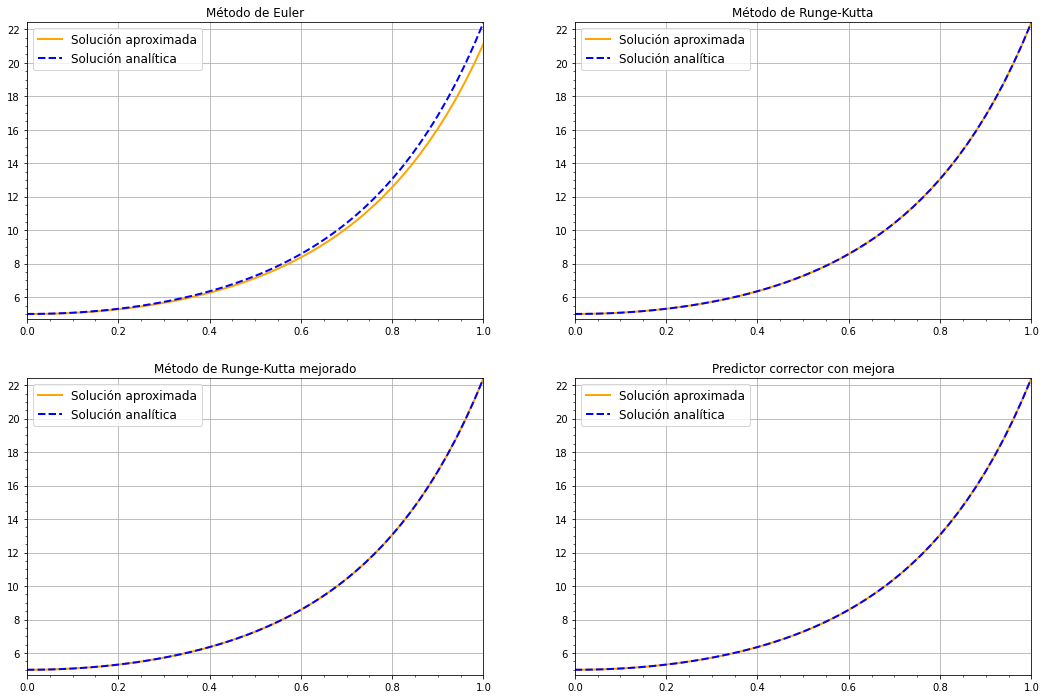

In [21]:
x_0, x_fin, y_0, h = 0, 1, 5, 0.02

x1,y1 = integrador1p(x_0, x_fin, y_0, ejemplo1, h, euler)
x2,y2 = integrador1p(x_0, x_fin, y_0, ejemplo1, h, rungekuta) #paso h
x3,y3 = rkm(x_0, x_fin, y_0, integrador1p, ejemplo1, h, rungekuta) #rkm
x4,y4 = integradormp(x_0, x_fin, y_0, ejemplo1, h, rungekuta, predcorr, 4)

#Graficamos 
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
ax[0,0].plot(x1,y1,label="Solución aproximada",linewidth=2, color='orange') #Euler
ax[0,0].plot(x1,sol_ejemplo1(x1),label="Solución analítica",linewidth=2,linestyle='dashed', color='blue') #Solución real 
ax[0,0].set_title('Método de Euler')
ax[0,0].set_xlim(min(x1), max(x1))
ax[0,0].set_ylim(min(sol_ejemplo1(x1))-0.3, max(sol_ejemplo1(x1)))
ax[0,0].grid()
ax[0,0].minorticks_on()
ax[0,0].legend(fontsize=12)

ax[0,1].plot(x2,y2,label="Solución aproximada",linewidth=2, color='orange') #Runge-Kutta
ax[0,1].plot(x1,sol_ejemplo1(x1),label="Solución analítica",linewidth=2,linestyle='dashed', color='blue')#Solución real
ax[0,1].set_title('Método de Runge-Kutta')
ax[0,1].set_xlim(min(x1), max(x1))
ax[0,1].set_ylim(min(sol_ejemplo1(x1))-0.3, max(sol_ejemplo1(x1)))
ax[0,1].grid()
ax[0,1].minorticks_on()
ax[0,1].legend(fontsize=12)

ax[1,0].plot(x3,y3,label="Solución aproximada",linewidth=2, color='orange') #Runge-Kutta mejorado
ax[1,0].plot(x1,sol_ejemplo1(x1),label="Solución analítica",linewidth=2,linestyle='dashed', color='blue')#Solución real
ax[1,0].set_title('Método de Runge-Kutta mejorado')
ax[1,0].set_xlim(min(x1), max(x1))
ax[1,0].set_ylim(min(sol_ejemplo1(x1))-0.3, max(sol_ejemplo1(x1)))
ax[1,0].grid()
ax[1,0].minorticks_on()
ax[1,0].legend(fontsize=12)

#predictor 
ax[1,1].plot(x4,y4,label="Solución aproximada",linewidth=2, color='orange') #Predictor corr
ax[1,1].plot(x1,sol_ejemplo1(x1),label="Solución analítica",linewidth=2,linestyle='dashed', color='blue')#Solución real
ax[1,1].set_title('Predictor corrector con mejora')
ax[1,1].set_xlim(min(x1), max(x1))
ax[1,1].set_ylim(min(sol_ejemplo1(x1))-0.3, max(sol_ejemplo1(x1)))
ax[1,1].grid()
ax[1,1].minorticks_on()
ax[1,1].legend(fontsize=12)

plt.show()

Los resultados obtenidos son esperables. El método de Euler, el más sencillo, presenta buenos resultados, aunque alejados levemente de los esperado. El método de Runge-Kutta de cuarto orden supone una mejora sustancial respecto al método anterior, lo cual se refleja en los resultados, con una aproximación muy ajustada a lo esperado. La mejora de este método no supone un gran cambio aparente, por lo que la representación del método y del método mejorado aparentan ser la misma figura. \\

El método predictor corrector, si bien da resultados también muy buenos resultados, en la práctica no se aprecia diferencia con los métodos Runge-Kutta simple y mejorado. Esto es de nuevo debido a la poca diferencia y a la representación de los datos, así como las escalas de los ejes, que hacen imposible la visualización de diferencias entre este método y los Runge-Kutta simple y mejorado. 

A modo de comparación, se graficará a continuación la diferencia entre el valor real esperado y las aproximaciones obtenidas por el método de Runge-Kutta, por la mejora de este y por el predictor corrector con mejora. 

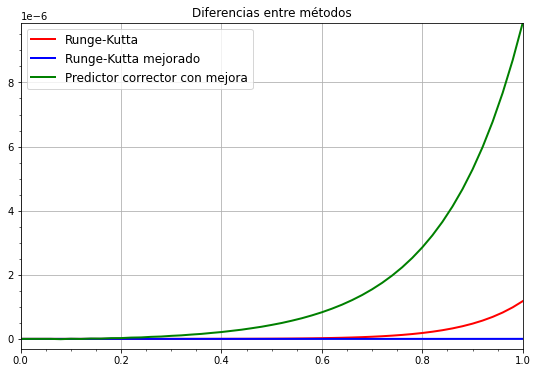

In [22]:
fig, ax = plt.subplots(1, figsize=(9, 6))

yr = np.zeros(len(y2)) #valor real - runge-kutta
yrm = np.zeros(len(y3)) #valor real - runge-kutta mejorado
ypcm = np.zeros(len(y4)) #valor real - predictor corrector
for i in range(len(y2)):
  yr[i] = sol_ejemplo1(x1[i]) - y2[i]
  yrm[i] = sol_ejemplo1(x1[i]) - y3[i]
  ypcm[i] = sol_ejemplo1(x1[i]) - y4[i]

ax.plot(x2, yr, label='Runge-Kutta', linewidth=2, color='red') #Euler
ax.plot(x2, yrm, label='Runge-Kutta mejorado', linewidth=2, color='blue') #Euler
ax.plot(x2, ypcm, label='Predictor corrector con mejora', linewidth=2, color='green') #Euler
ax.set_title('Diferencias entre métodos')
ax.set_xlim(min(x2), max(x2))
ax.set_ylim(min(ypcm)-0.3e-6, max(ypcm))
ax.grid()
ax.minorticks_on()
ax.legend(fontsize=12)

Se ve que el predictor corrector con mejora es el peor de los tres métodos atendiendo a los resultados, y que la mejora del método Runge-Kutta efectivamente da resultados mucho más precisos. \\

Habiendo comprobado el funcionamiento de los métodos programados, toca aplicarlos a un problema físico. Como ya se mencionó en la introducción, este será la dinámica de un péndulo doble dados ciertos valores iniciales para las posiciones y velocidades de ambas masas. Las ecuaciones del movimiento de este sistema son 
\begin{align}
\ddot{\theta}_1 &= \frac{-g(2m_1 + m_2)\sin\theta_1 - m_2g\sin{(\theta_1 - 2\theta_2)} - 2\sin{(\theta_1 - \theta_2)}m_2(\dot{\theta}_2l_2 + \dot{\theta}_1l_1\cos{(\theta_1 - \theta_2)})}{l_1(2m_1 + m_2 - m_2\cos{(2\theta_1 - 2\theta_2)})} \\
\ddot{\theta}_2 &= \frac{2\sin{(\theta_1 - \theta_2)}(\dot{\theta}_1l_1(m_1 + m_2) + g(m_1 + m_2)\cos{\theta_1} + \dot{\theta}_2l_2m_2\cos{(\theta_1 - \theta_2)}    )}{l_2(2m_1 + m_2 - m_2\cos{(2\theta_1 - 2\theta_2)})}
\end{align}

Para ello, se definirá la clase $\textit{oscilador}$, que será función de todos los parámetros que aparecen en las ecuaciones del movimiento, es decir, de la masa de ambos péndulos y de sus longitudes, así como de la gravedad (por defecto se tomará la gravedad media en la Tierra, pero dejo aquí sus valores medios en otros planetas para ir probando). 


*   Mercurio: 3.70 $m/s$
*   Venus: 8.87 $m/s$
*   La Tierra: 9.81 $m/s$
*   Marte: 3.72 $m/s$
*   Júpiter: 24.79 $m/s$
*   Saturno: 10.44 $m/s$
*   Urano: 8.87 $m/s$
*   Neptuno: 11.15 $m/s$




In [23]:
class oscilador:
  """Oscilador:
     g: gravedad 
     m1 = masa del primer péndulo
     m2 = masa del segundo péndulo
     l1 = longitus del primer péndulo
     l2 = longitud del segundo péndulo
  """
  def __init__(self, g = 9.81, m1 = 1, m2 = 1, l1 = 1, l2 = 1):
    self.g = g
    self.m1 = m1
    self.m2 = m2
    self.l1 = l1
    self.l2 = l2
  def __call__(self, x, y):
    theta1 = (-self.g*(2*self.m1 + self.m2)*np.sin(y[0,0]) - self.m2*self.g*np.sin(y[0,0] - 2*y[0,1]) - 2*np.sin(y[0,0] - y[0,1])*self.m2*(y[0,3]**2*self.l2 + y[0,2]**2*self.l1*np.cos(y[0,0] - y[0,1])))/(self.l1*(2*self.m1 + self.m2 - self.m2*np.cos(2*y[0,0] - 2*y[0,1])))
    theta2 = (2*np.sin(y[0,0] - y[0,1])*(y[0,2]**2*self.l1*(self.m1 + self.m2) + self.g*(self.m1 + self.m2)*np.cos(y[0,0]) + y[0,3]**2*self.l2*self.m2*np.cos(y[0,0] - y[0,1])))/(self.l2*(2*self.m1 + self.m2 - self.m2*np.cos(2*y[0,0] - 2*y[0,1])))
    #vector y de cuatro elementos: y[0,0] e y[0,1] las posiciones, y[0,2] e y[0,3] las velocidades del primer y segundo péndulo, respectivamente
    return np.array([y[0,2], y[0,3], theta1, theta2])
  def get_longi1(self):
    return self.l1
  def get_longi2(self):
    return self.l2

Para la resolución de estas ecuaciones diferenciales se ha reducido el orden de las mismas mediante el cambio de variable $y_i = \dot{\theta_i} \; (i = 1, 2)$, de modo que se tendrá el resultado en forma de un array con sus dos primeras componentes las velocidades y sus dos siguientes componentes las aceleraciones de los péndulos. Definimos un péndulo con las características que queramos (como ejemplo dejamos las características por defecto) y le damos condiciones iniciales para analizarlo.

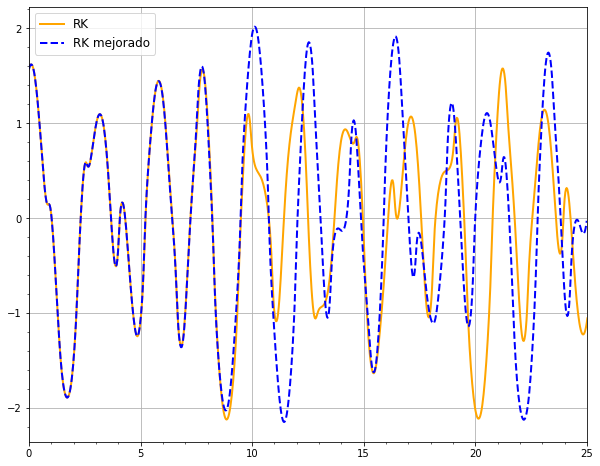

In [24]:
#mi oscilador (objeto del tipo un_oscilador)
pendulodoble1 = oscilador()

x_0 = 0.
yy_00 = np.array([90, 80, 1, 1]) #condiciones inciales en grados y metros por segundo
y_0 = np.array([yy_00[0]*np.pi/180, yy_00[1]*np.pi/180, yy_00[2], yy_00[3]])  #conversión de grados a radianes para operar
x_fin = 25.0
h = 0.03

xx2,yy2 = integrador1p(x_0, x_fin, y_0, pendulodoble1, h, rungekuta)
xx3, yy3 = rkm(x_0, x_fin, y_0, integrador1p, pendulodoble1, h, rungekuta)

#Graficamos los rollos

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(xx2,yy2[:,0],label="RK",linewidth=2, color='orange')
ax.plot(xx3,yy3[:,0],label="RK mejorado",linewidth=2, color='blue', linestyle='dashed')
ax.set_xlim(x_0,x_fin)
ax.grid()
ax.minorticks_on()
ax.legend(fontsize=12)
plt.show()

Como era de esperar, al tratarse de un sistema caótico, tenemos una gráfica que así lo refleja. Nótese que solo hemos representado los resultados de la masa 1 que, en ausencia de la segunda masa, se esperaría un comportamiento armónico típico de un péndul simple. Sin embargo, el mejor modo de visualizar el resultado de este sistema es animando el péndulo. Para ello simplemente es necesario calcular las posiciones en cartesianas a partir de la posición angular que ya tenemos. Con estas se conforma la trayectoria de cada péndulo. Al no tratarse de muchos datos, no se relenetiza (demasiado), la ejecución, por lo que no recortaremos los arrays de las trayectorias. Definimos una función que nos haga el cambio a cartesianas.

In [25]:
def traycar(l1, l2, y): #yy3 = y
  tray1 = np.zeros((len(y[:, 0]), 2))
  tray2 = np.zeros((len(y[:, 0]), 2))

  for i in range(len(y[:,0])):
    tray1[i, 0] = l1*np.sin(y[i,0])
    tray1[i, 1] = - l1*np.cos(y[i,0])
    tray2[i, 0] = l2*np.sin(y[i,1]) + l1*np.sin(y[i,0])
    tray2[i, 1] = - l2*np.cos(y[i,1]) - l1*np.cos(y[i,0])
  return tray1, tray2

Con una representación en el espacio de fases, la gráfica anterior (donde solo se representan los resultados para la masa 1) tomará una forma con la que estaremos más familizarizados: la trayectoria circular del péndulo simple como la trayectoria de la masa 1, y una trayectoria caótica para la masa 2

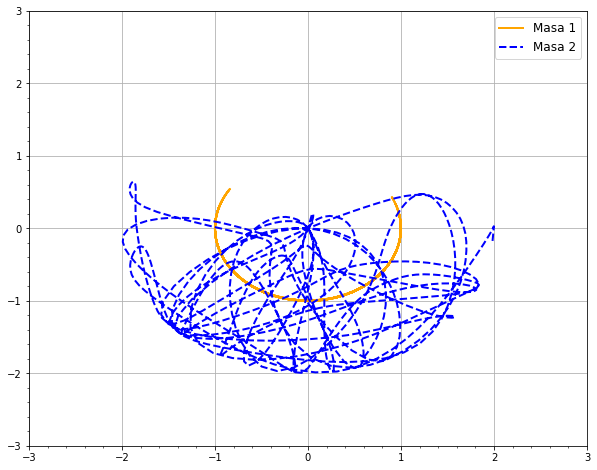

In [26]:
trayect1 = traycar(pendulodoble1.get_longi1(), pendulodoble1.get_longi2(), yy3)[0]
trayect2 = traycar(pendulodoble1.get_longi1(), pendulodoble1.get_longi2(), yy3)[1]
minmax1 = pendulodoble1.get_longi1() + pendulodoble1.get_longi2()

fig, ax = plt.subplots(figsize=(10, 8))
#ax.plot(xx1,yy1[:,0],label="Euler",linewidth=2, color='red')    #representamos la posicion solamente, elemento (columna) 0 del array solucion
ax.plot(trayect1[:, 0],trayect1[:, 1],label="Masa 1",linewidth=2, color='orange')
ax.plot(trayect2[:, 0],trayect2[:, 1],label="Masa 2",linewidth=2, color='blue', linestyle='dashed')
ax.set_ylim(-minmax1 - 1, minmax1 + 1)
ax.set_xlim(-minmax1 - 1, minmax1 + 1)
ax.grid()
ax.minorticks_on()
ax.legend(fontsize=12)
plt.show()

Como estamos tratando un sistema caótico, sabemos que una pequeña variación en las condiciones iniciales genera grandes cambios en la trayectoria. Además, como depende la gravedad, las masas y las longitudes, una variación de estos parámetros maneteniendo las condiciones iniciales también generará cambios importantes. Para este caso, variamos en 1 grado la posición de cada masa y graficamos el péndulo anterior y este para compararlos. Dejamos x_0, x_fin y h como en el caso anterior.

In [27]:
pendulodoble2 = oscilador()
minmax = max(pendulodoble1.get_longi1() + pendulodoble1.get_longi2(), pendulodoble2.get_longi1() + pendulodoble2.get_longi2())


yy_00 = np.array([91, 81, 1, 1]) #condiciones inciales en grados y metros por segundo
y_0 = np.array([yy_00[0]*np.pi/180, yy_00[1]*np.pi/180, yy_00[2], yy_00[3]])  #conversión de grados a radianes para operar
xx4, yy4 = rkm(x_0, x_fin, y_0, integrador1p, pendulodoble2, h, rungekuta)

trayect3 = traycar(pendulodoble2.get_longi1(), pendulodoble2.get_longi2(), yy4)[0]
trayect4 = traycar(pendulodoble2.get_longi1(), pendulodoble2.get_longi2(), yy4)[1]

Ya tenemos los dos péndulos y sus trayectorias. Los animamos y dejamos la traza de cada masa para una mejor visualización de los resultados dispares pese a las condiciones iniciales casi iguales

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.set_ylim(-minmax - 1, minmax + 1)
ax.set_xlim(-minmax - 1, minmax + 1)

#primer péndulo
masa1, = plt.plot([], [], 'ko', lw=2, markersize=8)
masa2, = plt.plot([], [], 'ko', lw=2, markersize=8)
linea1,= plt.plot([],[], 'k-')
linea2,= plt.plot([],[], 'k-')
rec1, = plt.plot([], [], 'r--', alpha = 0.35)
rec2, = plt.plot([], [], 'r--', alpha = 0.35)

#segundo péndulo
masa3, = plt.plot([], [], 'ko', lw=2, markersize=8)
masa4, = plt.plot([], [], 'ko', lw=2, markersize=8)
linea3,= plt.plot([],[], 'k-')
linea4,= plt.plot([],[], 'k-')
rec3, = plt.plot([], [], 'b--', alpha = 0.35)
rec4, = plt.plot([], [], 'b--', alpha = 0.35)

def animate(i):
  #animación del primer péndulo
  masa1.set_data(trayect1[i,0], trayect1[i,1]) 
  masa2.set_data(trayect2[i,0], trayect2[i,1])
  linea1.set_data([0,trayect1[i, 0]], [0, trayect1[i,1]])
  linea2.set_data([trayect1[i, 0], trayect2[i,0]], [trayect1[i, 1], trayect2[i,1]]) #([x1, x2], [y1, y2])
  rec1.set_data(trayect1[:i,0], trayect1[:i,1]) #:i para coger los valores hasta el elemento i-esimo
  rec2.set_data(trayect2[:i,0], trayect2[:i,1])

  masa3.set_data(trayect3[i,0], trayect3[i,1])
  masa4.set_data(trayect4[i,0], trayect4[i,1])
  linea3.set_data([0,trayect3[i, 0]], [0, trayect3[i,1]])
  linea4.set_data([trayect3[i, 0], trayect4[i,0]], [trayect3[i, 1], trayect4[i,1]])
  rec3.set_data(trayect3[:i,0], trayect3[:i,1])
  rec4.set_data(trayect4[:i,0], trayect4[:i,1])
  
  return masa1, masa2, rec1, rec2, masa3, masa4, rec3, rec4 

anim = animation.FuncAnimation(fig, animate, interval=25, frames=int(x_fin/h), repeat=False)

plt.close()
HTML(anim.to_html5_video())